In [2]:
import cv2
import numpy as np
import skimage
from matplotlib import pyplot as plt

In [3]:
def preprocess_page(page: np.ndarray, thresh=None):

    gray = cv2.cvtColor(page, cv2.COLOR_BGR2GRAY) if len(page.shape) == 3 else page

    if thresh is None:
        t, binary = cv2.threshold(
            gray,
            0,
            255,
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )

    else:
        t = float(thresh)
        _, binary = cv2.threshold(
            gray,
            t,
            255,
            cv2.THRESH_BINARY
        )

    return binary, t

In [4]:
def show_image(img, title=None):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = img

    plt.figure(figsize=(6, 6))
    if title:
        plt.title(title)
    if len(img_rgb.shape) == 2:
        plt.imshow(img_rgb, cmap='gray')
    else:
        plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

def show_image_with_points(img: np.ndarray,
                           points: np.ndarray,
                           title: str | None = None,
                           point_size: int = 30,
                           point_color: str = "red"):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = img

    plt.figure(figsize=(6, 6))
    if title:
        plt.title(title)

    if len(img_rgb.shape) == 2:
        plt.imshow(img_rgb, cmap="gray")
    else:
        plt.imshow(img_rgb)

    xs = points[:, 0]
    ys = points[:, 1]
    plt.scatter(xs, ys, s=point_size, c=point_color)

    plt.axis("off")
    plt.show()

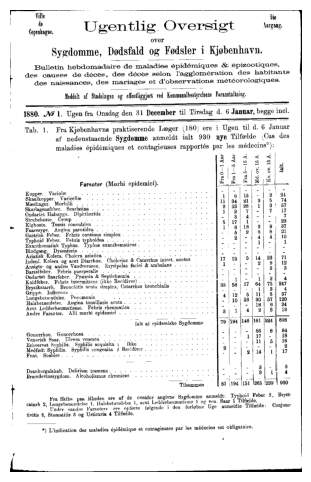

In [5]:
page = cv2.imread("page_1.png")

page, thresh = preprocess_page(page)

show_image(page)

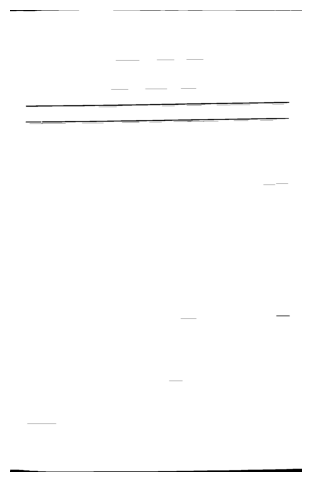

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
closed = cv2.morphologyEx(page, cv2.MORPH_CLOSE, kernel)
show_image(closed)

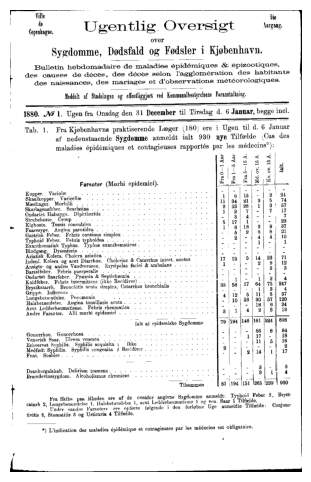

In [7]:
show_image(page)

In [8]:
import cv2
import numpy as np
from typing import List, Tuple, Dict, Optional

Line = Tuple[int, int, int, int]
Point = Tuple[float, float]


def to_gray(image: np.ndarray) -> np.ndarray:
    if image.ndim == 2:
        return image
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def detect_edges(page: np.ndarray) -> np.ndarray:
    gray = to_gray(page)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
    return edges


def detect_lines(edges: np.ndarray,
                 min_length_ratio: float = 0.6,
                 max_line_gap: int = 10,
                 hough_threshold: int = 100) -> List[Line]:
    h, w = edges.shape
    min_len = int(min(h, w) * min_length_ratio)
    raw = cv2.HoughLinesP(
        edges,
        1,
        np.pi / 180.0,
        threshold=hough_threshold,
        minLineLength=min_len,
        maxLineGap=max_line_gap,
    )
    if raw is None:
        return []
    raw = raw.reshape(-1, 4)
    return [tuple(map(int, l)) for l in raw]


def line_angle(line: Line) -> float:
    x1, y1, x2, y2 = line
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))


def split_horizontal_vertical(lines: List[Line],
                              angle_tol: float = 10.0) -> Tuple[List[Line], List[Line]]:
    horizontals: List[Line] = []
    verticals: List[Line] = []
    for line in lines:
        a = line_angle(line)
        if abs(a) <= angle_tol:
            horizontals.append(line)
        elif abs(abs(a) - 90.0) <= angle_tol:
            verticals.append(line)
    return horizontals, verticals


def line_center(line: Line) -> Point:
    x1, y1, x2, y2 = line
    return (0.5 * (x1 + x2), 0.5 * (y1 + y2))


def pick_extreme_line(lines: List[Line],
                      axis: int,
                      mode: str) -> Optional[Line]:
    if not lines:
        return None
    centers = np.array([line_center(l) for l in lines])
    values = centers[:, axis]
    if mode == "min":
        idx = int(np.argmin(values))
    else:
        idx = int(np.argmax(values))
    return lines[idx]


def fallback_box_from_edges(edges: np.ndarray) -> Dict[str, Line]:
    ys, xs = np.where(edges > 0)
    if len(xs) == 0 or len(ys) == 0:
        h, w = edges.shape
        return {
            "top": (0, 0, w - 1, 0),
            "bottom": (0, h - 1, w - 1, h - 1),
            "left": (0, 0, 0, h - 1),
            "right": (w - 1, 0, w - 1, h - 1),
        }
    x_min, x_max = int(xs.min()), int(xs.max())
    y_min, y_max = int(ys.min()), int(ys.max())
    return {
        "top": (x_min, y_min, x_max, y_min),
        "bottom": (x_min, y_max, x_max, y_max),
        "left": (x_min, y_min, x_min, y_max),
        "right": (x_max, y_min, x_max, y_max),
    }


def detect_border_lines(page: np.ndarray) -> Dict[str, Line]:
    edges = detect_edges(page)
    lines = detect_lines(edges)
    horizontals, verticals = split_horizontal_vertical(lines)

    top = pick_extreme_line(horizontals, axis=1, mode="min")
    bottom = pick_extreme_line(horizontals, axis=1, mode="max")
    left = pick_extreme_line(verticals, axis=0, mode="min")
    right = pick_extreme_line(verticals, axis=0, mode="max")

    if None in (top, bottom, left, right):
        return fallback_box_from_edges(edges)

    return {
        "top": top,      # (x1, y1, x2, y2)
        "bottom": bottom,
        "left": left,
        "right": right,
    }


def sample_line(line: Line, n: int) -> np.ndarray:
    x1, y1, x2, y2 = line
    xs = np.linspace(x1, x2, n)
    ys = np.linspace(y1, y2, n)
    return np.stack([xs, ys], axis=1)


def sample_border_points(border: Dict[str, Line],
                         samples_per_side: int = 16) -> np.ndarray:
    top_pts = sample_line(border["top"], samples_per_side)
    right_pts = sample_line(border["right"], samples_per_side)
    bottom_pts = sample_line(border["bottom"], samples_per_side)[::-1]
    left_pts = sample_line(border["left"], samples_per_side)[::-1]

    points = np.concatenate(
        [top_pts, right_pts[1:], bottom_pts[1:], left_pts[1:-1]],
        axis=0,
    )
    return points.astype(np.float32)


def generate_border_points(page: np.ndarray,
                           samples_per_side: int = 16) -> np.ndarray:
    border = detect_border_lines(page)
    return sample_border_points(border, samples_per_side)


In [9]:
points = generate_border_points(page, samples_per_side=20)

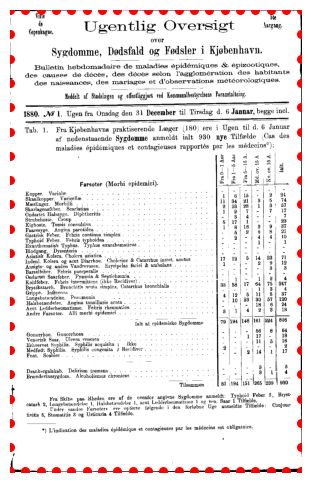

In [10]:
show_image_with_points(page,points)

In [11]:
def detect_page_lines(page,
                      min_length_ratio=0.2,
                      max_line_gap=10,
                      hough_threshold=80):
    edges = detect_edges(page)
    lines = detect_lines(
        edges,
        min_length_ratio=min_length_ratio,
        max_line_gap=max_line_gap,
        hough_threshold=hough_threshold,
    )
    horizontals, verticals = split_horizontal_vertical(lines)
    return horizontals, verticals


def border_bounds(border):
    top = border["top"]
    bottom = border["bottom"]
    left = border["left"]
    right = border["right"]

    y_top = 0.5 * (top[1] + top[3])
    y_bottom = 0.5 * (bottom[1] + bottom[3])
    x_left = 0.5 * (left[0] + left[2])
    x_right = 0.5 * (right[0] + right[2])

    return x_left, x_right, y_top, y_bottom


def filter_inner_lines(horizontals,
                       verticals,
                       border,
                       margin_ratio=0.03):
    x_left, x_right, y_top, y_bottom = border_bounds(border)
    width = x_right - x_left
    height = y_bottom - y_top

    margin_x = margin_ratio * width
    margin_y = margin_ratio * height

    inner_h = []
    inner_v = []

    for line in horizontals:
        cx, cy = line_center(line)
        if (x_left + margin_x <= cx <= x_right - margin_x and
                y_top + margin_y <= cy <= y_bottom - margin_y):
            inner_h.append(line)

    for line in verticals:
        cx, cy = line_center(line)
        if (x_left + margin_x <= cx <= x_right - margin_x and
                y_top + margin_y <= cy <= y_bottom - margin_y):
            inner_v.append(line)

    return inner_h, inner_v


def intersect_hv_line(h_line, v_line, eps=3.0):
    x1, y1, x2, y2 = h_line
    hx_min, hx_max = sorted([x1, x2])
    hy = 0.5 * (y1 + y2)

    x3, y3, x4, y4 = v_line
    vx = 0.5 * (x3 + x4)
    vy_min, vy_max = sorted([y3, y4])

    if hx_min - eps <= vx <= hx_max + eps and vy_min - eps <= hy <= vy_max + eps:
        return np.array([vx, hy], dtype=np.float32)
    return None


def intersections_from_lines(h_lines, v_lines, eps=3.0):
    points = []
    for h in h_lines:
        for v in v_lines:
            p = intersect_hv_line(h, v, eps=eps)
            if p is not None:
                points.append(p)
    if not points:
        return np.zeros((0, 2), dtype=np.float32)

    pts = np.stack(points, axis=0)
    rounded = np.round(pts).astype(np.int32)
    unique = np.unique(rounded, axis=0).astype(np.float32)
    return unique


def sample_multiple_lines(lines, n):
    if not lines:
        return np.zeros((0, 2), dtype=np.float32)
    arrays = [sample_line(l, n) for l in lines]
    pts = np.concatenate(arrays, axis=0)
    return pts.astype(np.float32)


def generate_inner_line_points(page,
                               border=None,
                               samples_per_horizontal=6,
                               samples_per_vertical=6,
                               use_intersections=True):
    if border is None:
        border = detect_border_lines(page)

    horizontals, verticals = detect_page_lines(page)
    inner_h, inner_v = filter_inner_lines(horizontals, verticals, border)

    pts_h = sample_multiple_lines(inner_h, samples_per_horizontal)
    pts_v = sample_multiple_lines(inner_v, samples_per_vertical)

    if use_intersections:
        pts_cross = intersections_from_lines(inner_h, inner_v)
        all_pts = np.concatenate([pts_h, pts_v, pts_cross], axis=0) if pts_cross.size else np.concatenate([pts_h, pts_v], axis=0)
    else:
        all_pts = np.concatenate([pts_h, pts_v], axis=0)

    if all_pts.size == 0:
        return all_pts

    rounded = np.round(all_pts).astype(np.int32)
    unique = np.unique(rounded, axis=0).astype(np.float32)
    return unique


def generate_all_control_points(page,
                                border_samples_per_side=4,
                                inner_samples_h=6,
                                inner_samples_v=6,
                                use_intersections=True):
    border = detect_border_lines(page)
    border_pts = sample_border_points(border, samples_per_side=border_samples_per_side)
    inner_pts = generate_inner_line_points(
        page,
        border=border,
        samples_per_horizontal=inner_samples_h,
        samples_per_vertical=inner_samples_v,
        use_intersections=use_intersections,
    )
    if inner_pts.size == 0:
        return border_pts
    all_pts = np.concatenate([border_pts, inner_pts], axis=0)
    rounded = np.round(all_pts).astype(np.int32)
    unique = np.unique(rounded, axis=0).astype(np.float32)
    return unique

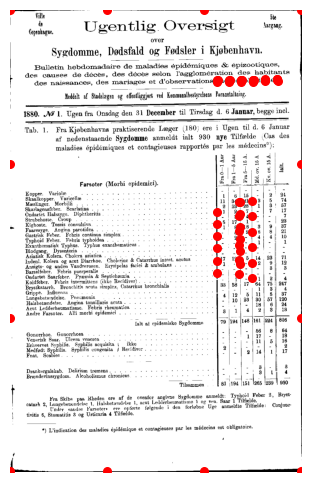

In [12]:
points = generate_all_control_points(page)
show_image_with_points(page,points)

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict


def ensure_binary(page: np.ndarray, thresh: int | None = None) -> np.ndarray:
    if page.ndim == 3:
        page = cv2.cvtColor(page, cv2.COLOR_BGR2GRAY)
    if thresh is None:
        _, binary = cv2.threshold(page, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, binary = cv2.threshold(page, thresh, 255, cv2.THRESH_BINARY)
    return binary


def foreground_mask(page: np.ndarray) -> np.ndarray:
    binary = ensure_binary(page)
    return binary < 128


def close_gaps(mask: np.ndarray, orientation: str, gap: int) -> np.ndarray:
    if orientation == "horizontal":
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (gap, 1))
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, gap))
    closed = cv2.morphologyEx(mask.astype(np.uint8) * 255, cv2.MORPH_CLOSE, kernel)
    return closed > 0


def runs_1d(values: np.ndarray) -> List[Tuple[int, int]]:
    runs: List[Tuple[int, int]] = []
    start = None
    for i, v in enumerate(values):
        if v:
            if start is None:
                start = i
        else:
            if start is not None:
                runs.append((start, i - 1))
                start = None
    if start is not None:
        runs.append((start, len(values) - 1))
    return runs


def group_segments_by_coord(
    segments: List[Tuple[int, int, int]],
    merge_tol: int,
    orientation: str,
) -> List[Dict]:
    if not segments:
        return []

    segments_sorted = sorted(segments)
    groups: List[List[Tuple[int, int, int]]] = []
    current = [segments_sorted[0]]

    for seg in segments_sorted[1:]:
        coord, s, e = seg
        last_coord, _, _ = current[-1]
        if abs(coord - last_coord) <= merge_tol:
            current.append(seg)
        else:
            groups.append(current)
            current = [seg]
    groups.append(current)

    lines: List[Dict] = []
    for g in groups:
        coords = [c for c, _, _ in g]
        starts = [s for _, s, _ in g]
        ends = [e for _, _, e in g]

        seg_min = min(starts)
        seg_max = max(ends)

        if orientation == "horizontal":
            y_min = min(coords)
            y_max = max(coords)
            lines.append(
                {
                    "orientation": "horizontal",
                    "segments": g,
                    "y_min": y_min,
                    "y_max": y_max,
                    "x0": seg_min,
                    "x1": seg_max,
                    "length": seg_max - seg_min + 1,
                }
            )
        else:
            x_min = min(coords)
            x_max = max(coords)
            lines.append(
                {
                    "orientation": "vertical",
                    "segments": g,
                    "x_min": x_min,
                    "x_max": x_max,
                    "y0": seg_min,
                    "y1": seg_max,
                    "length": seg_max - seg_min + 1,
                }
            )

    return lines


def detect_horizontal_lines(
    page: np.ndarray,
    gap: int = 5,
    min_run_ratio: float = 0.15,
    merge_tol: int = 3,
) -> Tuple[List[Dict], np.ndarray]:
    mask = foreground_mask(page)
    closed = close_gaps(mask, "horizontal", gap)

    h, w = closed.shape
    min_run = int(w * min_run_ratio)

    segments: List[Tuple[int, int, int]] = []
    for y in range(h):
        row = closed[y]
        for s, e in runs_1d(row):
            if e - s + 1 >= min_run:
                segments.append((y, s, e))

    lines = group_segments_by_coord(segments, merge_tol, "horizontal")
    return lines, closed


def detect_vertical_lines(
    page: np.ndarray,
    gap: int = 5,
    min_run_ratio: float = 0.15,
    merge_tol: int = 3,
) -> Tuple[List[Dict], np.ndarray]:
    mask = foreground_mask(page)
    closed = close_gaps(mask, "vertical", gap)

    h, w = closed.shape
    min_run = int(h * min_run_ratio)

    segments: List[Tuple[int, int, int]] = []
    for x in range(w):
        col = closed[:, x]
        for s, e in runs_1d(col):
            if e - s + 1 >= min_run:
                segments.append((x, s, e))

    lines = group_segments_by_coord(segments, merge_tol, "vertical")
    return lines, closed


def sample_horizontal_line(line: Dict, mask: np.ndarray, num_samples: int) -> np.ndarray:
    x0 = line["x0"]
    x1 = line["x1"]
    y_min = line["y_min"]
    y_max = line["y_max"]

    xs = np.linspace(x0, x1, num_samples)
    ys = []

    for x in xs:
        xi = int(round(x))
        xi = max(0, min(mask.shape[1] - 1, xi))

        col = mask[y_min : y_max + 1, xi]
        ys_idx = np.where(col)[0]
        if len(ys_idx) == 0:
            ys.append(0.5 * (y_min + y_max))
        else:
            ys.append(y_min + np.median(ys_idx))

    xs = xs.astype(float)
    ys = np.array(ys, dtype=float)
    pts = np.stack([xs, ys], axis=1)
    return pts.astype(np.float32)


def sample_vertical_line(line: Dict, mask: np.ndarray, num_samples: int) -> np.ndarray:
    y0 = line["y0"]
    y1 = line["y1"]
    x_min = line["x_min"]
    x_max = line["x_max"]

    ys = np.linspace(y0, y1, num_samples)
    xs = []

    for y in ys:
        yi = int(round(y))
        yi = max(0, min(mask.shape[0] - 1, yi))

        row = mask[yi, x_min : x_max + 1]
        xs_idx = np.where(row)[0]
        if len(xs_idx) == 0:
            xs.append(0.5 * (x_min + x_max))
        else:
            xs.append(x_min + np.median(xs_idx))

    ys = ys.astype(float)
    xs = np.array(xs, dtype=float)
    pts = np.stack([xs, ys], axis=1)
    return pts.astype(np.float32)


def sample_points_on_lines(
    lines_h: List[Dict],
    mask_h: np.ndarray,
    lines_v: List[Dict],
    mask_v: np.ndarray,
    num_samples: int,
) -> np.ndarray:
    pts_list: List[np.ndarray] = []

    for line in lines_h:
        pts_list.append(sample_horizontal_line(line, mask_h, num_samples))

    for line in lines_v:
        pts_list.append(sample_vertical_line(line, mask_v, num_samples))

    if not pts_list:
        return np.zeros((0, 2), dtype=np.float32)

    pts = np.concatenate(pts_list, axis=0)
    return pts.astype(np.float32)

def filter_points_by_margin(points: np.ndarray,
                            img_shape: tuple[int, int],
                            border_margin: int) -> np.ndarray:
    if border_margin <= 0 or points.size == 0:
        return points
    h, w = img_shape
    m = border_margin
    xs = points[:, 0]
    ys = points[:, 1]
    mask = (
        (xs >= m) &
        (xs <= w - 1 - m) &
        (ys >= m) &
        (ys <= h - 1 - m)
    )
    return points[mask]

def line_points(
    page: np.ndarray,
    num_samples_per_line: int = 10,
    detect_vertical: bool = True,
    detect_horizontal: bool = True,
    gap: int = 5,
    min_run_ratio_h: float = 0.15,
    min_run_ratio_v: float = 0.2,
    merge_tol: int = 3,
    border_margin: int = 0,
) -> np.ndarray:
    lines_h: List[Dict] = []
    lines_v: List[Dict] = []
    binary = ensure_binary(page)
    mask_h = np.zeros_like(binary, dtype=bool)
    mask_v = np.zeros_like(binary, dtype=bool)

    if detect_horizontal:
        lines_h, mask_h = detect_horizontal_lines(
            page,
            gap=gap,
            min_run_ratio=min_run_ratio_h,
            merge_tol=merge_tol,
        )

    if detect_vertical:
        lines_v, mask_v = detect_vertical_lines(
            page,
            gap=gap,
            min_run_ratio=min_run_ratio_v,
            merge_tol=merge_tol,
        )

    pts = sample_points_on_lines(
        lines_h,
        mask_h,
        lines_v,
        mask_v,
        num_samples_per_line,
    )

    pts = filter_points_by_margin(pts, binary.shape, border_margin)
    return pts

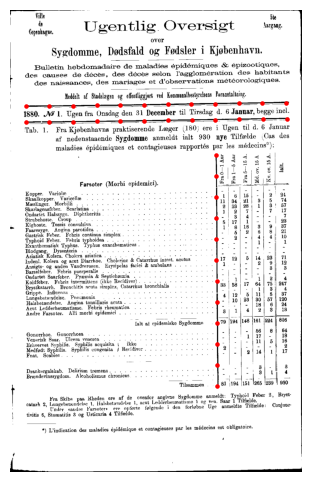

In [ ]:
points = line_points(
    page,
    num_samples_per_line=12,
    detect_vertical=True,
    detect_horizontal=True,
    gap=5,
    min_run_ratio_h=0.22,
    min_run_ratio_v=0.16,
    merge_tol=3,
    border_margin=15
)
show_image_with_points(page,points,point_size=5)

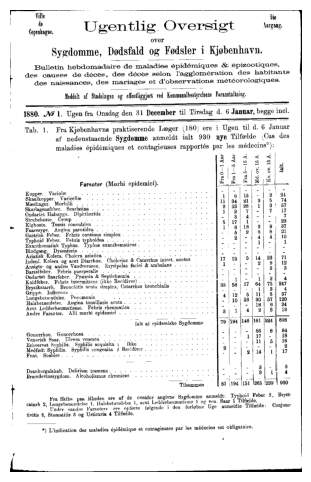

In [16]:
show_image(page)